# Importing packages

In [16]:
# Importing necessary packages:

from glob import glob
import numpy as np
import pandas as pd

import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import PROPERTY_LABELS as PL
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
from polyphys.analyze import measurer
from polyphys.manage import utilizer

# Project details
#project = 'HnsCub'
#project = 'TransFociCyl'
#project = 'SumRuleCyl'
project = 'TransFociCub'
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)

['../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize.parquet.brotli']


# Auto-correlation functions

##### Note: In a given space, ensAvg groups differs in their values of bulk volume fraction of crowders (column name: phi_c_bulk)

### Theoretical background:

Below, all the several definitions of autocorrelation function (acf) in the literature are listed. Assuming $A(t)$ is a discrete time-varying property of interest and is collected every $M$ timesteps in a molecular dynamics simulation with the time step $\Delta t$ and time unit $\hat{t}$. First, we define the mean (or average) and unbiased variance of $A(t)$ as what follows

$$\langle A\rangle=\frac{1}{t_{max}}\sum_{t=1}^{t_{max}}A(t)$$
$$\sigma^2_A=\langle A^2 \rangle-\langle A\rangle^2=\frac{1}{t_{max}-1}\sum_{t=1}^{t_{max}}(A(t)-\langle A\rangle)^2$$

where $t_{max}$ is the total number of collected cofigurations or timesteps, or simply the size of $A(t)$, implying the total number of simulated timesteps is $t_{max}\times M$. Given this definition, the acf has been defined in the following ways in the literature:

1. Allen and Tildesley define the *non-normalized* acf in "Computer simulation of liquids - 2017" as

$$c_{AA}(h) = \frac{1}{h_{max}}\sum_{h_0=1}^{h_{max}}A(h_0)A(h_0+h)$$

where $h_{max}=\frac{t_{max}-1}{h}$

2. *1989 - Murat M Greet GS - Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation* defines the acf in "Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation - 1989" as

$$c_{AA}(h) =\frac{\langle (A(h)-\langle A \rangle)(A(0)-\langle A \rangle)\rangle}{\sigma^2_A}=\frac{\langle A(h)A(0)\rangle-\langle A \rangle \langle A(0) \rangle}{\sigma^2_A}$$

See the rest of this artciel to see how correlation time is calculated. See the rest of this artciel to see how correlation time is calculated.

3. In *1989 - Grest GS Kremer K Witten TA et el - Relaxation of Self-Entangled Many-Arm Star Polymers, 1987 - Grest GS Kremer K Witten TA - Structure of Many-Arm Star Polymers A Molecular Dynamics Simulation, and 1977 - Kranbuehl DE Verdier PH - Relaxation of the aspherical shapes of random-coil polymer chains*, the acf is

$$c_{AA}(h) =\frac{\langle A(h)A(0)\rangle-\langle A \rangle^2}{\sigma^2_A}$$

where the average is performed over the initial time steps $h=h_0=0$ taken every $K$ timesteps. Kranbuehl and Verdier runs the whole simulation several times the relaxation time of the end-to-end length.

4. In *1978 - Rapaport DC - Molecular dynamics simulation of polymer chains with excluded volum, and 1979 - Bishop M Ceperley D Frisch HL - Molecular dynamics of polymeric systems* the afc is given by

$$c_{AA}(h) =\frac{\langle A(h)A(h_0+h)\rangle-\langle A(h_0) \rangle^2}{\sigma^2_A(h_0)}$$

where

$$\sigma^2_A(h_0)=\langle A(h_0)^2 \rangle-\langle A(h_0)\rangle^2$$

The averaging should be done over ensembles; however, in practice, the ensemble average is replaced by the time average provided that the timesteps or time interval between successvie $h_0$ values are sufficently lagre so the configurations are uncorrelated.

5. *1981 - Bruns W Bansal R - Molecular dynamics study of a single polymer chain in solution* defines the afc as

$$c_{\vec{A}\vec{A}}(h) = \frac{\sum_{h_0=1}^{t_{max}-h}\vec{A}(h_0).\vec{A}(h_0+h)}{\sum_{h_0=1}^{t_{max}-h}\vec{A}^2(h_0)}$$

where $\vec{A}$ is a vector quantity and $h_0$ is summed over $1,1+p,1+2p,\dots$ instead of $h_0=1,2,3,\dots,t_{max}-h$. For a scalar quantity, this definition is used:

$$c_{AA}(h) = \frac{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A(h_0)A(h_0+h)-\sum_{h_0=1}^{t_{max}-h}A(h_0)\sum_{h_0=1}^{t_{max}-h}A(h_0+h)}{\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0)]^2}-\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)]^2}}=
\frac{\langle A(h_0)A(h_0+h)\rangle-\langle A(h_0)\rangle\langle A(h_0+h)\rangle}{\sqrt{\langle A^2(h_0)\rangle-\langle A(h_0)\rangle^2}-\sqrt{\langle A^2(h_0+h)\rangle-\langle A(h_0+h)\rangle^2}}$$

6. *Brockwell PJ Davis RA - 2016 - Introduction to Time Series and Forecasting* defines the afc in the following way

$$c_{AA}(h) = \frac{cov_{A}(h)}{\sigma_A^2} = \frac{1}{\sigma_A^2}\frac{1}{t_{max}}\sum_{h_0=1}^{t_{max}-h} [A(h_0+h)-\langle A\rangle][A(h_0)-\langle A\rangle]$$





### How to run this Notebook:

1. Check ((spaces_to_read**
2. Check **group** and **species**.
3. check **database**.
4. delete extra **physical** properties based on the preoject.
5. check **nlags** and **ticks**.
6. check **parser** and **spaces_title**.

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/polyphys/manage/parser.py:1538: UserWarning: It is assumed that 'nc' is the last attribute short-key in a lineage_name of types: 'ensemble', 'ensemble_long', 'whole', 'segment'.
  warnings.warn(convention_warning, UserWarning)
/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/polyphys/manage/parser.py:1538: UserWarning: It is assumed that 'nc' is the last attribute short-key in a lineage_name of types: 'ensemble', 'ensemble_long', 'whole', 'segment'.
  warnings.warn(convention_warning, UserWarning)
/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/polyphys/manage/parser.py:1538: UserWarning: It is assumed that 'nc' is the last attribute short-key in a lineage_name of types: 'ensemble', 'ensemble_long', 'whole', 'segment'.
  warnings.warn(convention_warning, UserWarning)


Index(['t_index', 'asphericityTMon', 'time_dump_dt', 'space', 'ensemble_long',
       'ensemble', 'nmon_small', 'nmon_large', 'dmon_large', 'dcrowd',
       'phi_c_bulk_round', 'asphericityTMon-acfLowerCi',
       'asphericityTMon-acfUpperCi', 'gyrTMon', 'gyrTMon-acfLowerCi',
       'gyrTMon-acfUpperCi', 'shapeTMon', 'shapeTMon-acfLowerCi',
       'shapeTMon-acfUpperCi', 'lag_time', 'lag_index', 'space_title',
       'space_title_short', 'universe'],
      dtype='object')


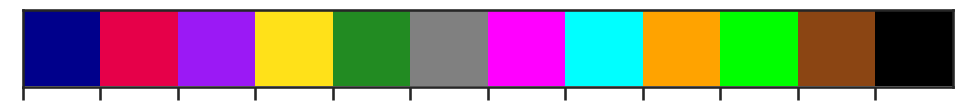

In [17]:
# read data
acf = []
acf_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('acf.parquet.brotli')]
# define lag times
dumping_freq = {
        'TransFociCyl': 'bdump',
        'TransFociCub': 'bdump',
        'SumRuleCyl': 'bdump',
        'HnsCub': 'ndump'
    }
for space_db in acf_space_dbs:
    space_acf = pd.read_parquet(space_db)
    ensembles = space_acf['ensemble_long'].unique()
    space_acf.rename(columns={'time':'time_dump_dt'}, inplace=True)
    s_title_style = ''
    s_title_style_short = ''
    universe_title_style = ''
    space_acf['lag_time'] = 0
    space_acf['lag_index'] = 0
    space_acf['space_title'] = ''
    space_acf['space_title_short'] = ''
    space_acf['universe'] = ''
    for ens in ensembles:
        s_info = PD[project]['parser'](
        ens,
        'ensemble_long',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
        )
        if project == 'TransFociCub':
            s_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            s_title_style_short = fr"${{a_M}}/{{a_m}}={s_info.dmon_large}$"
            universe_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'TransFociCyl':
            s_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            s_title_style_short = fr"${{a_M}}/{{a_m}}={s_info.dmon_large}$"
            universe_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'SumRuleCyl':
            s_title_style = (fr"$N={s_info.nmon},$ " +
                                 fr"$D={s_info.dcyl},$ " +
                                 fr"$a_c={s_info.dcrowd}$")
            s_title_style_short = ""
            universe_title_style = ""
        elif project == 'HnsCub':
            s_title_style = (fr"$N={s_info.nmon},$ " +
                                 fr"$N_{{hns}}={s_info.nhns},$ " +
                                 fr"a_c={s_info.dcrowd}$")
            s_title_style_short = (fr"$N_{{hns}}={s_info.nhns},$ " +
                                   fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            universe_title_style = fr"$N={s_info.nmon}$"
        else:
            raise ValueError(f"Project: '{project}' is not defined.")
        cond = space_acf['ensemble_long']==ens
        space_acf.loc[cond,'space_title'] = s_title_style
        space_acf.loc[cond,'space_title_short'] = s_title_style_short
        space_acf.loc[cond,'universe'] = universe_title_style
        n_lags = len(space_acf.loc[cond,'time_dump_dt'])
        bdump = getattr(s_info, dumping_freq[project])
        space_acf.loc[cond,'lag_time'] = \
            space_acf.loc[cond,'time_dump_dt'] * bdump
        space_acf.loc[cond,'lag_index'] = np.arange(0,n_lags,dtype=np.int_)
    acf.append(space_acf)

acf = pd.concat(acf,axis=0, ignore_index=True)
acf.reset_index(inplace=True,drop=True)
# a sorted list of unique spaces in the dataset
spaces = acf.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
acf['phi_c_bulk_round'] = acf['phi_c_bulk'].apply(
    utilizer.round_up_nearest, args=[divisor, round_to]
)
# phi_c to drop
acf = acf.loc[~acf['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
acf.reset_index(inplace=True, drop=True)
# droping some of the columns
cols_to_drop = [col for col in acf.columns if (col.endswith('sem') | col.endswith('var'))] + ['phi_c_bulk']
acf.drop(columns=cols_to_drop,inplace=True)
# add rounded phi_crds to the dataset
# Define a list of unique physical properties:
ext = '-acf-mean'
properties = [property_.split(ext)[0] for property_ in acf.columns if property_.endswith(ext)]
properties.sort()
# change the name of cols after fiding properties based on "-acf-mean" in their name
new_columns = [prop.split(ext)[0] for prop in acf.columns]
acf.columns = new_columns
# change the name of cols after fining properties based on "-mean" in their name
new_columns = [prop.split('-mean')[0] for prop in acf.columns]
acf.columns = new_columns
print(acf.columns)
spaces = acf.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
sns.palplot(AC)

## ACF with CIs: phi_c as col per space: not fcompleted

In [ ]:
height = 3
aspect = 1 * 1.618 # Golden ratio
font_scale = 1.4
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = 'viridis_r'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.96, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
x_prop = 'lag_index'
plot_details = {
    'TransFociCyl': [('dmon_large', 'phi_c_bulk_round', 1, (0.76, 0.9)),
                  ( 'phi_c_bulk_round','dmon_large', 3, (0.92, 0.9))],
    'TransFociCub': [('dmon_large', 'phi_c_bulk_round', 1, (0.76, 0.9)),
                  ( 'phi_c_bulk_round','dmon_large', 3, (0.92, 0.9))]
}
for title_style in ['talk', 'paper']:
    for (col_attr, hue_attr, col_wrap, bbox_to_a) in plot_details[project]:
        for space in spaces:
            acf_space = acf.loc[acf['space']==space]
            for y_prop in properties:
                y_high = y_prop + '-acfUpperCi'
                y_low = y_prop + '-acfLowerCi'
                col_order = sorted(acf[col_attr].unique())
                hue_order = sorted(acf[hue_attr].unique())
                f_grid = sns.FacetGrid(
                    acf_space,
                    col=col_attr,
                    col_order=col_order,
                    col_wrap=col_wrap,
                    hue=hue_attr,
                    hue_order=hue_order,
                    height=height,
                    aspect=aspect,
                    palette=color_palette,
                    sharex=True,
                    sharey='row',
                    legend_out=True
                )

                f_grid.map(
                    plt.plot,
                    x_prop,
                    y_prop,
                    #marker='o',
                    alpha=0.7,
                    #ls='--',
                    #markerfacecolor='none'
                )
                f_grid.add_legend(title=AL[hue_attr],
                    **legend_kws)
                f_grid.set_titles("")
                f_grid.map(plt.axhline, y=0, ls='--', c='black', zorder=0)
                f_grid.map(
                    plt.fill_between,
                    x_prop,
                    y_low,
                    y_high, 
                    clip_on=False, alpha=0.2, zorder=2)
                f_grid.set_axis_labels(AL[x_prop], SML[y_prop]['acf'])
                f_grid.set(xticks=np.arange(0,8000,2000))
                for idx, (ax, (col_name)) in enumerate(zip(f_grid.axes.flat,col_order)):
                    ax.text(0.75,0.8, AL[col_attr] + fr"$={col_name}$",
                            color='black',
                            ha="center",
                            va="center",
                            bbox=global_bbox,
                            transform=ax.transAxes)
                f_grid.tight_layout(w_pad=0.5, h_pad=0.5)
                if title_style == 'talk':
                    f_grid.fig.suptitle(
                        acf_space['universe'].values[0],
                        **fig_title_kws
                    )
                output = "-".join(
                    ["Auto_correlations", title_style, y_prop, hue_attr, col_attr, project]
                )
                f_grid.savefig(
                    save_to + output + "." + ext,
                    bbox_inches='tight'
                )
                plt.close()

## TransFoci:

In [18]:
height = 4
aspect = 1 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = 'viridis_r'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 1.02, 'ha': 'center'}
x_prop = 'lag_index'
plot_details = {
    'TransFociCyl': [('dmon_large', 'phi_c_bulk_round', 1),
                  ( 'phi_c_bulk_round','dmon_large', 4)],
    'TransFociCub': [('dmon_large', 'phi_c_bulk_round', 1),
                  ( 'phi_c_bulk_round','dmon_large', 4)]
}
for title_style in ['talk', 'paper']:
    for (col_attr, hue_attr, col_wrap) in plot_details[project]:
        col_order = sorted(acf[col_attr].unique())
        hue_order = sorted(acf[hue_attr].unique())
        if hue_attr == 'dmon_large':
            color_palette = AC[6:6+len(hue_order)]
        else:
            color_palette = 'viridis_r'
        sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font=font_family,
            font_scale=font_scale,
            rc=rc_params
        )
        for y_prop in properties:
            y_high = y_prop + '-acfUpperCi'
            y_low = y_prop + '-acfLowerCi'
            f_grid = sns.FacetGrid(
                acf,
                col=col_attr,
                col_order=col_order,
                col_wrap=col_wrap,
                hue=hue_attr,
                hue_order=hue_order,
                height=height,
                aspect=aspect,
                palette=color_palette,
                sharex=True,
                sharey='row',
                legend_out=True
            )

            f_grid.map(
                plt.plot,
                x_prop,
                y_prop,
                #marker='o',
                alpha=0.7,
                #ls='--',
                #markerfacecolor='none'
            )
            f_grid.add_legend(title=AL[hue_attr],
                **legend_kws)
            f_grid.set_titles("")
            f_grid.map(plt.axhline, y=0, ls='--', c='black', zorder=0)
            if hue_attr == 'dmon_large':
                f_grid.map(
                    plt.fill_between,
                    x_prop,
                    y_low,
                    y_high, 
                    clip_on=False, alpha=0.2, zorder=2)
            f_grid.set_axis_labels(AL[x_prop], SML[y_prop]['acf'])
            f_grid.set(xticks=np.arange(0,8000,2000))
            for idx, (ax, (col_name)) in enumerate(zip(f_grid.axes.flat,col_order)):
                ax.text(0.75,0.8, AL[col_attr] + fr"$={col_name}$",
                        color='black',
                        ha="center",
                        va="center",
                        bbox=global_bbox,
                        transform=ax.transAxes)
            f_grid.tight_layout(w_pad=0.5, h_pad=0.5)
            if title_style == 'talk':
                f_grid.fig.suptitle(
                    acf_space['universe'].values[0],
                    **fig_title_kws
                )
            output = "-".join(
                ["Auto_correlations", title_style, y_prop, hue_attr, col_attr, project]
            )
            f_grid.savefig(
                save_to + output + "." + ext,
                bbox_inches='tight'
            )
            plt.close()